In [1]:
from argparse import ArgumentParser
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl

import sys, os
sys.path.append(os.path.abspath(".."))
from spaf import get_encoder_spaf

/mnt/first19T/zhangning/miniconda3/envs/spafoundation/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#create model for spatial gene expressions prediction
class SpaFoundation_geneprediction(pl.LightningModule):
    def __init__(self,n_genes=250, dim=768, learning_rate=1e-5):
        super().__init__()
        self.learning_rate = learning_rate
        self.ibotmodel=get_encoder_spaf()
        
        self.gene_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, n_genes)
        )

        self.n_genes=n_genes

    def forward(self, patches):
        
        h = self.ibotmodel(patches)
        x = self.gene_head(h)
        return x

    def training_step(self, batch):      
        patch, exp = batch
        pred = self(patch)
        loss = F.mse_loss(pred.view_as(exp), exp)
        self.log('train_loss', loss)
        return loss

    def test_step(self, batch):
        patch, center, exp = batch
        pred = self(patch, center)
        loss = F.mse_loss(pred.view_as(exp), exp)
        self.log('test_loss', loss)

    def configure_optimizers(self):
        optim=torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        StepLR = torch.optim.lr_scheduler.StepLR(optim, step_size=50, gamma=0.9)
        optim_dict = {'optimizer': optim, 'lr_scheduler': StepLR}
        return optim_dict

    @staticmethod
    def add_model_specific_args(parent_parser):
        parser = ArgumentParser(parents=[parent_parser], add_help=False)
        parser.add_argument('--learning_rate', type=float, default=0.0001)
        return parser

In [3]:
from torch.utils.data import DataLoader
from dataset.dataset import ViT_SKIN
def get_train_loader(dataset,fold,batchsize):
    dataset = ViT_SKIN(train=True, fold=fold)
    train_loader = DataLoader(dataset, batch_size=batchsize, num_workers=4, shuffle=True)
    return train_loader

def get_test_loader(dataset,fold,test_slice,batchsize):
    dataset = ViT_SKIN(train=False, fold=fold,test_slice=test_slice)
    test_loader = DataLoader(dataset, batch_size=batchsize, num_workers=4, shuffle=False)

    return test_loader

In [4]:
import argparse
from utils import *
skin_slice_num = [3, 3, 3, 3]

# SpaFoundation train and test
def train_and_test(args, fold):
    n_genes = args.genes_num
    train_test = args.train_test

    # train
    if train_test:
        print(f"Start training fold {fold}...")
        train_loader = get_train_loader(
            dataset=args.dataset,
            fold=fold,
            batchsize=args.batchsize
        )
        model = SpaFoundation_geneprediction(
            n_genes=n_genes, 
            learning_rate=args.learning_rate
        )
        trainer = get_pltrainer(
            trainepochs=args.max_epoch,
            device_num=args.device_num,
            tag=args.tag,
            fold=fold
        )
        trainer.fit(model, train_loader)
        os.rename(
            f"results/{args.tag}/last.ckpt",
            f"results/{args.tag}/fold_{fold}_train_final_model.ckpt"
        )

    # test
    print(f"Start testing fold {fold}...")

    slices_for_patient = skin_slice_num[fold]
    print(f"Patient {fold} has {slices_for_patient} slices.")

    checkpoint_path = f"results/{args.tag}/fold_{fold}_train_final_model.ckpt"
    model = SpaFoundation_geneprediction.load_from_checkpoint(
        checkpoint_path,
        n_genes=n_genes,
        learning_rate=args.learning_rate
    )

    # test every slice
    for slice_idx in range(slices_for_patient):
        print(f"Testing slice {slice_idx} for patient {fold}...")
        test_loader = get_test_loader(
            dataset=args.dataset,
            fold=fold,
            test_slice=slice_idx,
            batchsize=args.batchsize
        )
        pred, truth = model_predict(model, test_loader, device="cuda")
        print(f"Patient: {fold}, Slice: {slice_idx}")
        performance(pred=pred, true=truth)


def get_args(argv=None):
    parser = argparse.ArgumentParser(
        description="Using SpaFoundation to predict gene expressions."
    )

    parser.add_argument("--dataset", type=str, default="cscc", choices=["her2st", "cscc"])
    parser.add_argument("--device_num", type=int, default=0)
    parser.add_argument("--genes_num", type=int, default=250)
    parser.add_argument("--genes_type", type=str, default="HEG", choices=["HVG", "HEG"])
    parser.add_argument("--tag", type=str, default="cscc_test")
    parser.add_argument("--batchsize", type=int, default=64)
    parser.add_argument("--max_epoch", type=int, default=20)
    parser.add_argument("--learning_rate", type=float, default=1e-5)
    parser.add_argument(
        "--train_test",
        action="store_false",
        default=True,
        help="whether to train and test or just test"
    )

    if argv is None:
        import sys
        argv = sys.argv[1:]

    args, _ = parser.parse_known_args(argv)
    return args


if __name__ == "__main__":
    args = get_args()

    save_path = f"results/{args.tag}"
    check_and_create_folder(save_path)
    seed_torch(2024)

    print("---Use the model named SpaFoundation---")

    for i in range(0, 1):  # (0,4) run all patients
        train_and_test(args, i)


The folder results/cscc_test has been founded!
---Use the model named SpaFoundation---
Start training fold 0...
Training the slides: ['P5_ST_rep1', 'P5_ST_rep2', 'P5_ST_rep3', 'P9_ST_rep1', 'P9_ST_rep2', 'P9_ST_rep3', 'P10_ST_rep1', 'P10_ST_rep2', 'P10_ST_rep3']
Loading data...
(6721, 250) (6721, 2) (6721, 2)
Take key state_dict in provided checkpoint dict


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Pretrained weights found at /mnt/first19T/zhangning/SpaFoundation/spaf/spafoundation_1m_vitb16.pth and loaded with msg: <All keys matched successfully>


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name      | Type              | Params
------------------------------------------------
0 | ibotmodel | VisionTransformer | 85.8 M
1 | gene_head | Sequential        | 193 K 
------------------------------------------------
86.0 M    Trainable params
0         Non-trainable params
86.0 M    Total params
343.970   Total estimated model params size (MB)


Epoch 19: 100%|██████████| 106/106 [30:32<00:00, 17.29s/it, loss=0.441]   
Start testing fold 0...
Patient 0 has 3 slices.
Take key state_dict in provided checkpoint dict
Pretrained weights found at /mnt/first19T/zhangning/SpaFoundation/spaf/spafoundation_1m_vitb16.pth and loaded with msg: <All keys matched successfully>
Testing slice 0 for patient 0...
Testing the slides: ['P2_ST_rep1']
Loading data...
(666, 250) (666, 2) (666, 2)
Patient: 0, Slice: 0
Median correlation across genes (PCC):  0.30407506085970837
Testing slice 1 for patient 0...
Testing the slides: ['P2_ST_rep2']
Loading data...
(646, 250) (646, 2) (646, 2)
Patient: 0, Slice: 1
Median correlation across genes (PCC):  0.3186970918496124
Testing slice 2 for patient 0...
Testing the slides: ['P2_ST_rep3']
Loading data...
(638, 250) (638, 2) (638, 2)
Patient: 0, Slice: 2
Median correlation across genes (PCC):  0.30895701228547645


In [5]:
# Min-Max normalization
def min_max_normalization(data):
    data_min = np.min(data)
    data_max = np.max(data)
    return (data - data_min) / (data_max - data_min) if data_max > data_min else np.zeros_like(data)

In [6]:
from dataset.dataset import SKIN_VIS
patient_name='P2'
slice_index='rep2'

weight_path='results/cscc_test/fold_0_train_final_model.ckpt'#model weight---->change
model = SpaFoundation_geneprediction.load_from_checkpoint(weight_path,n_genes=250, learning_rate=1e-5)
device = torch.device('cpu')

dataset = SKIN_VIS(patient_name=patient_name,slice_index=slice_index)
test_loader = DataLoader(dataset, batch_size=64, num_workers=4)
preds, gt, ct = model_predict_vis(model, test_loader, attention=False, device = device)

gene_list = list(np.load('dataset/cscc/genes_cscc_heg.npy',allow_pickle=True))

Take key state_dict in provided checkpoint dict
Pretrained weights found at /mnt/first19T/zhangning/SpaFoundation/spaf/spafoundation_1m_vitb16.pth and loaded with msg: <All keys matched successfully>
Loading data...
(646, 250) (646, 2) (646, 2)
(646, 250)


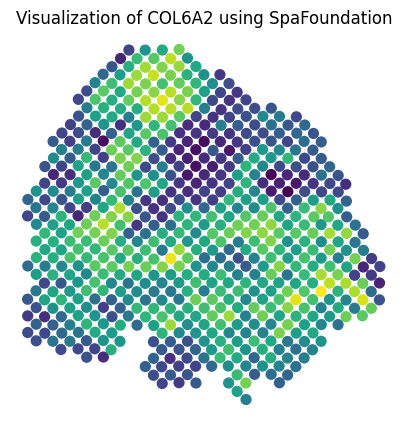

In [7]:
import matplotlib.pyplot as plt
'Visualization of a single gene using SpaFoundation'
centers=ct

gene_name = "COL6A2" 

if gene_name in gene_list:
    gene_index = gene_list.index(gene_name)

    
    selected_pred = preds[:, gene_index]

    spa_expressions = min_max_normalization(selected_pred)

    # draw
    plt.figure(figsize=(5, 5))
    plt.scatter(
        [c[0] for c in centers], 
        [c[1] for c in centers],
        c=spa_expressions,
        cmap="viridis",
        s=50,
        alpha=1.0
    )
    plt.gca().invert_yaxis()
    plt.axis("off")
    plt.title(f"Visualization of {gene_name} using SpaFoundation")
    plt.show()

else:
    print(f"Gene {gene_name} not found in gene_list!")
